In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical

# Data Download 
Upload kaggle API credentials to runtime

In [ ]:
# Upload Kaggle credentials to runtime prior to running this block
with open('./kaggle.json', 'r') as f:
    data = json.load(f)
    os.environ['KAGGLE_USERNAME'] = data['username']
    os.environ['KAGGLE_KEY'] = data['key']

In [ ]:
data_dir = "/content/drive/MyDrive/assets/data/Fer2013"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [ ]:
os.chdir(data_dir)
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 1.02MB/s]
100% 92.0M/92.0M [00:00<00:00, 101MB/s] 

 88% 17.0M/19.3M [00:00<00:00, 71.3MB/s]
100% 19.3M/19.3M [00:00<00:00, 74.3MB/s]
 91% 88.0M/96.6M [00:01<00:00, 97.4MB/s]
100% 96.6M/96.6M [00:01<00:00, 84.9MB/s]
 92% 71.0M/77.3M [00:00<00:00, 74.8MB/s]
100% 77.3M/77.3M [00:01<00:00, 78.9MB/s]


In [ ]:
!tar -xvf fer2013.tar.gz
!unzip test.csv.zip
!unzip train.csv.zip
!unzip icml_face_data.csv.zip

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  icml_face_data.csv.zip
  inflating: icml_face_data.csv      


In [ ]:
!rm fer2013.tar.gz test.csv.zip train.csv.zip icml_face_data.csv.zip

In [ ]:
!mv fer2013/fer2013.csv ./

# Dataset

In [3]:
# Change data directory (icml_face_data) accoringly
data_dir = "/content/drive/MyDrive/assets/data/Fer2013"
data = pd.read_csv(data_dir + '/icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


## Filter dataset to 2 classes = [Happy, Sad]

In [4]:
# emotions = {0: 'Angry',
#             1: 'Disgust',
#             2: 'Fear',
#             3: 'Happy',
#             4: 'Sad',
#             5: 'Surprise',
#             6: 'Neutral'}

# emotions_filtered = {3:'Happy',
#                      4:'Sad'
#                     }


convert_emotions = {3: 0,
                    4: 1}

selected_classes = list(convert_emotions.keys())

selected_emotions = {0: 'Happy',
                     1: 'Sad'}

In [5]:
data_filtered = pd.DataFrame(columns=['emotion', ' Usage', ' pixels'])
for i, row in enumerate(data.index):
    if data.loc[row, 'emotion'] in selected_classes:
        data_filtered = data_filtered.append(data.iloc[i])
data_filtered

,emotion,Usage,pixels
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
6,4,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,Training,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,Training,85 84 90 121 101 102 133 153 153 169 177 189 1...
14,3,Training,4 2 13 41 56 62 67 87 95 62 65 70 80 107 127 1...
...,...,...,...
35869,3,PrivateTest,217 220 222 223 223 224 225 223 223 225 223 22...
35873,4,PrivateTest,54 57 77 122 121 76 73 80 58 22 26 27 35 41 66...
35878,3,PrivateTest,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...


In [6]:
data_filtered.reset_index(inplace=True)
data_filtered.drop(['index'], axis=1, inplace=True)
data_filtered

,emotion,Usage,pixels
0,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
1,4,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
2,3,Training,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
3,3,Training,85 84 90 121 101 102 133 153 153 169 177 189 1...
4,3,Training,4 2 13 41 56 62 67 87 95 62 65 70 80 107 127 1...
...,...,...,...
15061,3,PrivateTest,217 220 222 223 223 224 225 223 223 225 223 22...
15062,4,PrivateTest,54 57 77 122 121 76 73 80 58 22 26 27 35 41 66...
15063,3,PrivateTest,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
15064,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...


In [7]:
import copy

new_data = copy.deepcopy(data_filtered)
for i in range(len(new_data)):
    new_data.emotion[i] = convert_emotions[new_data.emotion[i]]

new_data

,emotion,Usage,pixels
0,1,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
1,1,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
2,0,Training,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
3,0,Training,85 84 90 121 101 102 133 153 153 169 177 189 1...
4,0,Training,4 2 13 41 56 62 67 87 95 62 65 70 80 107 127 1...
...,...,...,...
15061,0,PrivateTest,217 220 222 223 223 224 225 223 223 225 223 22...
15062,1,PrivateTest,54 57 77 122 121 76 73 80 58 22 26 27 35 41 66...
15063,0,PrivateTest,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
15064,0,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...


## Data Preparation

In [8]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(12, 7))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(selected_emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    num_classes = len(new_data['emotion'].value_counts())
    fig, axs = plt.subplots(1, num_classes, figsize=(15, 6))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(num_classes):
        idx = new_data[new_data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(selected_emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = selected_emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(selected_emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(selected_emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [9]:
new_data[' Usage'].value_counts()

Training       12045
PublicTest      1548
PrivateTest     1473
Name:  Usage, dtype: int64

In [10]:
train_image_array, train_image_label = prepare_data(new_data[new_data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(new_data[new_data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(new_data[new_data[' Usage']=='PublicTest'])

In [11]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [12]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

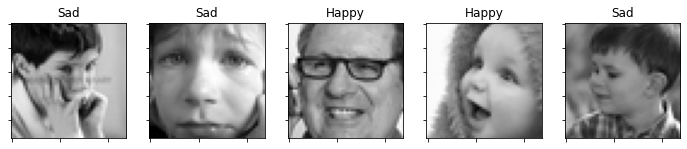

In [13]:
plot_examples()

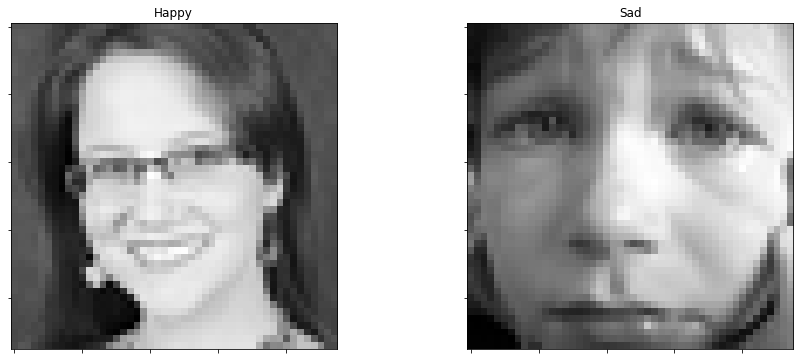

In [14]:
plot_all_emotions()

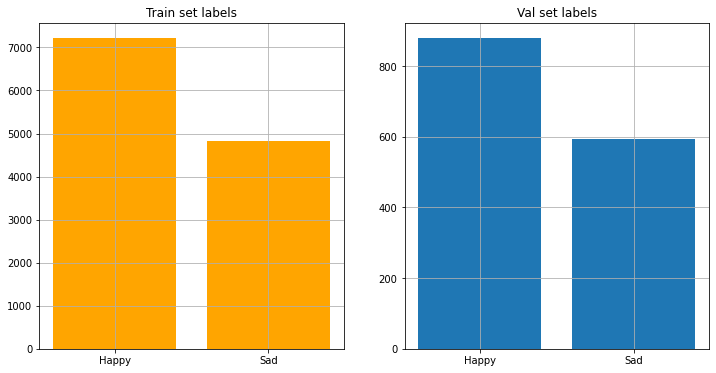

In [15]:
plot_compare_distributions(train_labels, val_labels, title1='Train set labels', title2='Val set labels')

In [16]:
class_weight = dict(zip(range(0, 2), (((new_data[new_data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(new_data[new_data[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.5990037359900373, 1: 0.40099626400996263}

# Define Model

In [27]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))   # Change final activation input to num_classes==2

In [28]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

# Train

In [29]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 50
BATCH_SIZE = 64

callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[callbacks])

Epoch 1/50
189/189 [==============================] - 2s 7ms/step - loss: 0.3143 - accuracy: 0.6012 - val_loss: 0.6591 - val_accuracy: 0.6001
Epoch 2/50
189/189 [==============================] - 1s 5ms/step - loss: 0.2793 - accuracy: 0.6633 - val_loss: 0.5932 - val_accuracy: 0.6626
Epoch 3/50
189/189 [==============================] - 1s 5ms/step - loss: 0.2572 - accuracy: 0.7128 - val_loss: 0.5276 - val_accuracy: 0.7223
Epoch 4/50
189/189 [==============================] - 1s 5ms/step - loss: 0.2475 - accuracy: 0.7286 - val_loss: 0.5235 - val_accuracy: 0.7196
Epoch 5/50
189/189 [==============================] - 1s 5ms/step - loss: 0.2377 - accuracy: 0.7398 - val_loss: 0.4947 - val_accuracy: 0.7352
Epoch 6/50
189/189 [==============================] - 1s 5ms/step - loss: 0.2277 - accuracy: 0.7568 - val_loss: 0.4775 - val_accuracy: 0.7475
Epoch 7/50
189/189 [==============================] - 1s 5ms/step - loss: 0.2193 - accuracy: 0.7708 - val_loss: 0.4561 - val_accuracy: 0.7733
Epoch 

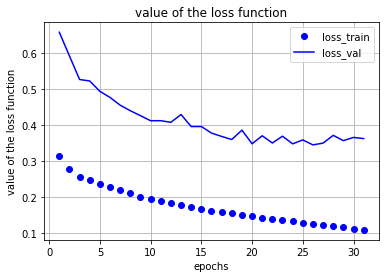

In [30]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

In [33]:
path = '/content/ckpt_2_expressions.hdf5'
model.save(path)

In [35]:
model.load_weights(path)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test Accuracy:', test_acc)

49/49 [==============================] - 0s 3ms/step - loss: 0.3602 - accuracy: 0.8488
Test Accuracy: 0.8488371968269348


# Random prediction

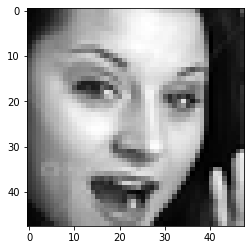

Output:  [0.9570875  0.04291246]
Model predict:  Happy
True answer:  Happy


In [38]:
# Get random image in test dataset
rand = random.choice(range(len(test_images)))

image = test_images[rand]

plt.imshow(image.reshape(48,48), cmap=plt.get_cmap('gray'))
plt.show()

# Feature scaling
image = np.expand_dims(image,axis=0)

# Prediction
predict = model.predict(image)[0]
print("Output: ", predict)
print("Model predict: ", selected_emotions[np.argmax(predict)])
print("True answer: ", selected_emotions[np.argmax(test_labels[rand])])